In [1]:
import sqlite3
import pandas as pd
import numpy as np

from datetime import datetime
from dateutil.relativedelta import relativedelta

from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt 
import seaborn as sns # Import seaborn

from datetime import datetime
from datetime import date
from dateutil import parser

from collections import defaultdict

from warnings import simplefilter
import time

## Read the dataframe from eda and visualization

In [2]:
# Import data frame from eda and visualization
curr_date = "2023-04-20"
pickle_file = 'sa-eda-' + curr_date + '.pkl'
pickle_file_path = 'data/' + pickle_file
df_main_nn = pd.read_pickle(pickle_file_path)

In [3]:
# Show all columns
pd.options.display.max_columns = None

# Ignore warnings
pd.options.mode.chained_assignment = None
simplefilter(action="ignore",category=FutureWarning)

In [4]:
# Calculate age of players
hp = 'home_player_'
ap = 'away_player_'
for i in range(1, 12):
    hp_n = hp+str(i)
    ap_n = ap+str(i)
    df_main_nn['date'] = pd.to_datetime(df_main_nn['date'])
    df_main_nn[hp_n+"_birthday"] = pd.to_datetime(df_main_nn[hp_n+"_birthday"])
    df_main_nn[ap_n+"_birthday"] = pd.to_datetime(df_main_nn[ap_n+"_birthday"])
    
    df_main_nn[hp_n+"_age"] = (df_main_nn['date'].dt.year - df_main_nn[hp_n+"_birthday"].dt.year)
    df_main_nn[ap_n+"_age"] = (df_main_nn['date'].dt.year - df_main_nn[ap_n+"_birthday"].dt.year)   

In [5]:
# Determining the outcome (Win | [Draw, Loss]) - This is the target
df_main_nn['outcome'] = (df_main_nn["home_team_goal"] > df_main_nn["away_team_goal"])

In [6]:
df_main_nn = df_main_nn.sort_values(['home_team_api_id', 'date'])

In [7]:
# Feature engineering: Long-term history - Amount of wins in the last 10 games
df_main_nn['last_ten'] = False
df_main_nn['last_ten'] = df_main_nn.groupby('home_team_api_id')['outcome'].rolling(window=10, min_periods=1, closed="left").sum().reset_index(0, drop=True)
df_main_nn = df_main_nn[~df_main_nn.isnull().any(axis=1)]

In [8]:
# Feature engineering: Mid-term history - Amount of wins in the last 5 games
df_main_nn['last_five'] = False
df_main_nn['last_five'] = df_main_nn.groupby('home_team_api_id')['outcome'].rolling(window=5, min_periods=1, closed="left").sum().reset_index(0, drop=True)
df_main_nn = df_main_nn[~df_main_nn.isnull().any(axis=1)]

In [9]:
# Feature engineering: Short-term history - Amount of wins in the last 3 games
df_main_nn['last_three'] = False
df_main_nn['last_three'] = df_main_nn.groupby('home_team_api_id')['outcome'].rolling(window=3, min_periods=1, closed="left").sum().reset_index(0, drop=True)
df_main_nn = df_main_nn[~df_main_nn.isnull().any(axis=1)]

In [10]:
# Feature engineering: Team height (Average height of players (Home | Away))
#                      Team weight (Average weight of players (Home | Away))
#                      Team age (Average age of players (Home | Away))
#                      Team FIFA rating (Average FIFA rating of players (Home | Away))
#                      Team Body Mass Index (Average BMI of players (Home | Away))

hp = 'home_player_'
hp_col_list_height = [hp+str(i)+'_height' for i in range(1,12)] 
hp_col_list_weight = [hp+str(i)+'_weight' for i in range(1,12)] 
hp_col_list_age = [hp+str(i)+'_age' for i in range(1,12)]
hp_col_list_rating = [hp+str(i)+'_rating' for i in range(1,12)]    

ap = 'away_player_'
ap_col_list_height = [ap+str(i)+'_height' for i in range(1,12)] 
ap_col_list_weight = [ap+str(i)+'_weight' for i in range(1,12)]
ap_col_list_age = [ap+str(i)+'_age' for i in range(1,12)]
ap_col_list_rating = [ap+str(i)+'_rating' for i in range(1,12)] 

df_main_nn[hp+'height_total'] = df_main_nn[hp_col_list_height].sum(axis=1)
df_main_nn[ap+'height_total'] = df_main_nn[ap_col_list_height].sum(axis=1)

df_main_nn[hp+'weight_total'] = df_main_nn[hp_col_list_weight].sum(axis=1)
df_main_nn[ap+'weight_total'] = df_main_nn[ap_col_list_weight].sum(axis=1)

df_main_nn[hp+'rating_total'] = df_main_nn[hp_col_list_rating].sum(axis=1)
df_main_nn[ap+'rating_total'] = df_main_nn[ap_col_list_rating].sum(axis=1)

df_main_nn[hp+'age_total'] = df_main_nn[hp_col_list_age].sum(axis=1)
df_main_nn[ap+'age_total'] = df_main_nn[ap_col_list_age].sum(axis=1)

df_main_nn[hp+"height_average"] = df_main_nn['home_player_height_total']/11
df_main_nn[ap+"height_average"] = df_main_nn['away_player_height_total']/11

df_main_nn[hp+"weight_average"] = df_main_nn['home_player_weight_total']/11
df_main_nn[ap+"weight_average"] = df_main_nn['away_player_weight_total']/11

df_main_nn[hp+'age_average'] = (df_main_nn[hp+'age_total']/11)
df_main_nn[ap+'age_average'] = (df_main_nn[ap+'age_total']/11)

df_main_nn[hp+'rating_average'] = (df_main_nn[hp+'rating_total']/11)
df_main_nn[ap+'rating_average'] = (df_main_nn[ap+'rating_total']/11)
 
df_main_nn['home_team_bmi'] = ((df_main_nn['home_player_weight_total']/2.20462)/((df_main_nn['home_player_height_total']/100)**2))*11
df_main_nn['away_team_bmi'] = ((df_main_nn['away_player_weight_total']/2.20462)/((df_main_nn['away_player_height_total']/100)**2))*11

In [11]:
df_main_nn['avg_height_diff'] = df_main_nn[hp+'height_average'] - df_main_nn[ap+'height_average'] 
df_main_nn['avg_weight_diff'] = df_main_nn[hp+'weight_average'] - df_main_nn[ap+'weight_average'] 
df_main_nn['avg_rating_diff'] = df_main_nn[hp+'rating_average'] - df_main_nn[ap+'rating_average']
df_main_nn['avg_age_diff'] = df_main_nn[hp+'age_average'] - df_main_nn[ap+'age_average']
df_main_nn['avg_bmi_diff'] = df_main_nn['home_team_bmi'] - df_main_nn['away_team_bmi'] 

In [12]:
attributes = ["last_ten","last_five","last_three",hp+"height_average",ap+"height_average",hp+"weight_average",
              ap+"weight_average",hp+'age_average',ap+'age_average',hp+'rating_average',ap+'rating_average',
              'home_team_bmi'] # ,'away_team_bmi'
len(attributes)

12

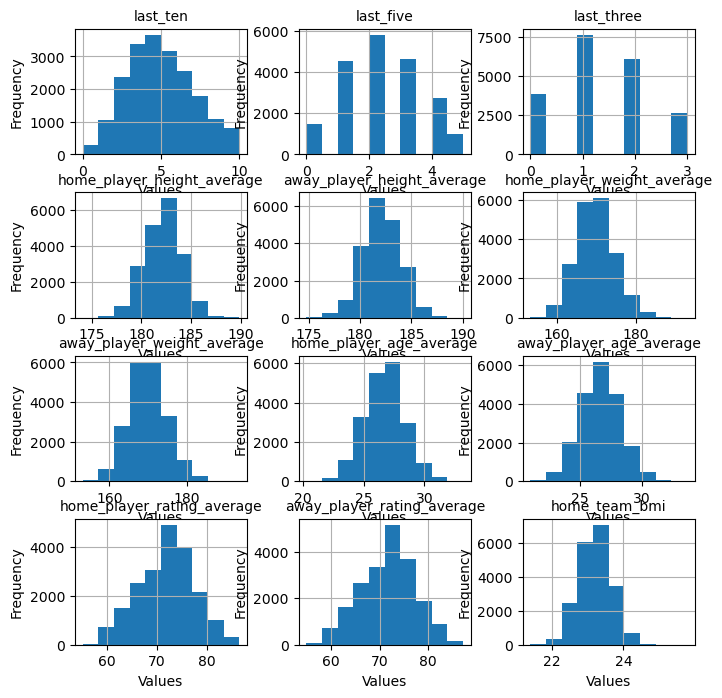

In [13]:
# Create a figure with two subplots
fig, axs = plt.subplots(4,3,figsize=(8, 8))
axs = axs.ravel()

for i,atts in enumerate(attributes):
    df_main_nn.hist(column=atts, bins=10, ax=axs[i])
    axs[i].set_title(atts,fontsize=10)
    axs[i].set_xlabel('Values',fontsize=10)
    axs[i].set_ylabel('Frequency',fontsize=10)

In [14]:
# General statistics of game outcomes
count_home_team_win = df_main_nn['outcome'].value_counts()[True]
count_home_team_not_win = df_main_nn['outcome'].value_counts()[False]
game_sum = count_home_team_win + count_home_team_not_win 
print("Home team win count")
print(count_home_team_win)
print("\nHome team no win count")
print(count_home_team_not_win)
print("\nActual win percentage for home team")
print((count_home_team_win / game_sum )* 100)

Home team win count
9319

Home team no win count
10863

Actual win percentage for home team
46.17480923595283


In [15]:
df_main_nn["goal_diff"] = df_main_nn["home_team_goal"].sub(df_main_nn["away_team_goal"],axis=0)

In [16]:
def rolling_sum_goal_diff(df, home_team_id, current_date):
    team_games = df[(df['home_team_api_id'] == home_team_id) & (df['date'] < current_date)].tail(10)
    goal_difference = team_games['home_team_goal'].sum() - team_games['away_team_goal'].sum()
    return goal_difference

In [17]:
df_main_nn['last_10_diff'] = df_main_nn.apply(lambda row: rolling_sum_goal_diff(df_main_nn, row['home_team_api_id'], row['date']), axis=1)

In [18]:
curr_date = date.today().strftime('%Y-%m-%d')
pickle_file = 'sa-preprocessing-' + curr_date + '.pkl'
pickle_file_path = 'data/' + pickle_file
df_main_nn.to_pickle(pickle_file_path)
print('Saved dataframe into .pkl file')

Saved dataframe into .pkl file
